# Flux Extract from SMA images #
Authors: Kirsten R. Hall, Eric Koch, Joshua Lovell, Jakob den Brok, ...
June 2024

This notebook will demonstrate how we extract fluxes from SMA (and other interferometric data) in the event that the source is point-like, extended and can be approximated by a two dimensional Gaussian, or it is extended and non-Gaussian. 

## Learning Goals ##
* plotting images with contours
* determining the noise in the map
* extracting source fluxes based on the level of its resolution in the image (unresolved, partially resolved, abnormal morphology)

## Requires ##

```
pip install numpy
pip install scipy
pip install matplotlib
pip install astropy
```

sidenote: CASA has excellent tools for extracting fluxes from point sources and extended sources that are well approximated by a 2D gaussian. These are the image-plane tool "imfit" as well as the uv-plane tool "uvmodelfit". 

We start by importing our necessary packages

In [2]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from matplotlib.patches import Ellipse
from photutils import aperture_photometry
from astropy.table import hstack
from photutils import CircularAperture
from photutils import CircularAnnulus
from photutils import EllipticalAnnulus
from scipy import integrate
from astropy.modeling import models, fitting

Read in the data. We will use the clean image to locate the source, and the primary beam corrected image to extract the appropriate flux. 

In [3]:
filename = '/Users/kirstenhall/astro/ACT_dsfg/GrallaFollowUp/J0038_natural_SMA225GHz.fits' #/your/path/to/imagefits/file
hdu = fits.open(filename)[0]
wcs = WCS(hdu.header).celestial

Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [5]:
filename_pbcor = '/Users/kirstenhall/astro/ACT_dsfg/GrallaFollowUp/J0038_natural_pbcor.fits' #/your/path/to/pbcorfits/file
hdu_pbcor = fits.open(filename_pbcor)[0]
wcs_pbcor = WCS(hdu_pbcor.header).celestial

Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


A function to extract the beam information

In [6]:
def getbeam(hdr):
    return hdr['BMAJ'], hdr['BMIN'], hdr['BPA']

In [7]:
beam = getbeam(hdu.header)
cdelt = hdu.header['CDELT2']
if beam[2] < 0:
    bpa = beam[2]+180
else:
    bpa = beam[2]

We will also read the representative frequency of these data from the header

In [117]:
Freq = hdu.header['CRVAL3']*u.Hz
print(Freq.to(u.GHz))

225.0007920868 GHz


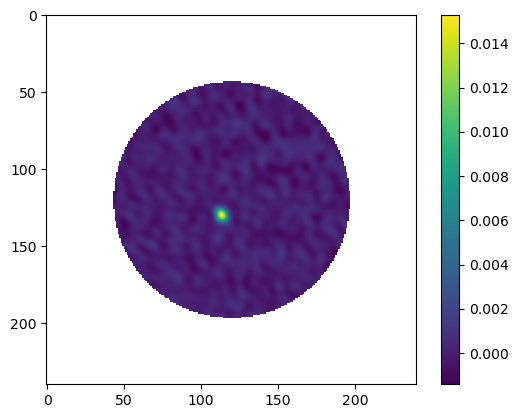

In [118]:
data_array = hdu.data[0][0]
maxloc = np.where(data_array == np.nanmax(data_array.flatten()))
aperture = CircularAnnulus((int(maxloc[0]),int(maxloc[1])), r_in=30, r_out=50)
rms=np.sqrt(aperture.do_photometry(data_array**2)[0]/aperture.area)[0] #Jy/beam

plt.imshow(data_array)
plt.colorbar()

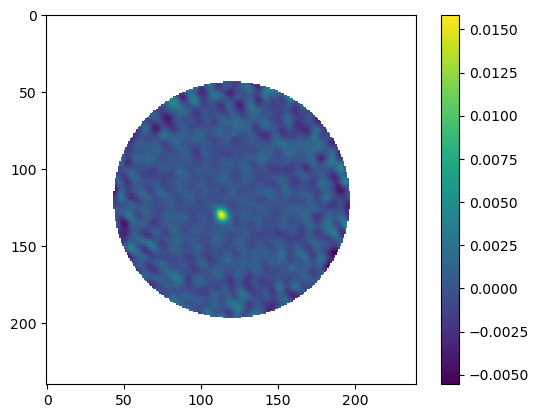

In [120]:
data_array_pbcor = hdu_pbcor.data[0][0]
plt.imshow(data_array_pbcor)
plt.colorbar()

This is a 2D array in which outside the circular beam the data values are NaN, so we need to either mask those (or convert the NaNs to zeros) or crop the image to continue with our analysis. We will convert the NaNs to zeros here. 

In [121]:
isnan_sel = np.isnan(data_array_pbcor)
data_array_pbcor[isnan_sel] = 0.0

Define two dimensional Gaussian function

In [122]:
"""
Factor with which to multiply Gaussian 1-sigma standard deviation to
convert it to full width at half maximum (FWHM).
"""
gaussian_sigma_to_fwhm = 2.0 * np.sqrt(2.0 * np.log(2.0))

"""
Factor with which to multiply Gaussian full width at half maximum (FWHM)
to convert it to 1-sigma standard deviation.
"""
gaussian_fwhm_to_sigma = 1.0 / gaussian_sigma_to_fwhm

In [123]:
def fit_2dgaussian(array, yme, xme, fwhmx=4, fwhmy=4, theta=0, full_output=False):
    gauss = models.Gaussian2D(amplitude=np.nanmax(array.flatten()), x_mean=xme,
                              y_mean=yme, x_stddev=fwhmx*gaussian_fwhm_to_sigma,
                              y_stddev=fwhmy*gaussian_fwhm_to_sigma, theta=theta)
    # Levenberg-Marquardt algorithm
    fitter = fitting.LevMarLSQFitter(calc_uncertainties=True)
    y, x = np.indices(array.shape)
    fit = fitter(gauss, x, y, array, maxiter=1000, acc=1e-08)
    mean_y = fit.y_mean.value
    mean_x = fit.x_mean.value
    fwhm_y = fit.y_stddev.value*gaussian_sigma_to_fwhm
    fwhm_x = fit.x_stddev.value*gaussian_sigma_to_fwhm
    amplitude = fit.amplitude.value
    theta = fit.theta.value
    amperr = fit.amplitude.std
    fwhm_yerr = fit.y_stddev.std*gaussian_sigma_to_fwhm
    fwhm_xerr = fit.x_stddev.std*gaussian_sigma_to_fwhm

    if full_output:
        return mean_y, mean_x, fwhm_y, fwhm_x, fwhm_yerr, fwhm_xerr, amplitude, amperr, theta
    else:
        return mean_y, mean_x, fwhm_y, fwhm_x, amplitude, amperr, theta

In [124]:
Fit_params = fit_2dgaussian(data_array_pbcor, maxloc[0], maxloc[1], fwhmx = beam[1]/cdelt, fwhmy = beam[0]/cdelt, theta=bpa*np.pi/180)

In [125]:
print(beam[0]/cdelt, beam[1]/cdelt, Fit_params[2], Fit_params[3])

7.604781627656991 5.8540973663328115 7.7162370578254 6.091356611261326


Right away we see that the best-fit 2D Gaussian has full-width at half maxima in both directions that are less than 1 pixel greater than the size of the beam. This indicates that this source is a point-source in this image, given its resolution, and therefore we can take the flux density of this source to be the peak value (amplitude) of the best-fit 2D Gaussian.

In [126]:
F225 = Fit_params[4]*u.Jy #225 GHz peak flux in units of Jy/beam, but it is a point source so this is the representative flux density of the source over 1 beam in units of Jy
F225err = Fit_params[5]*u.Jy

In [127]:
print(F225.to(u.mJy), F225err.to(u.mJy)) #mJy is a more useful unit here

16.22760797327214 mJy 2.666640206429508 mJy


Next we consider a different source for which the flux can be approximated by a 2D Gaussian, but it is more extended than the beam (partially resolved).

In [139]:
filename = '/Users/kirstenhall/astro/ACT_dsfg/GrallaFollowUp/J0116_natural_SMA228.5GHz.fits'
hdu = fits.open(filename)[0]
wcs = WCS(hdu.header).celestial

Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [140]:
filename_pbcor = '/Users/kirstenhall/astro/ACT_dsfg/GrallaFollowUp/J0116_natural_pbcor.fits'
hdu_pbcor = fits.open(filename_pbcor)[0]
wcs_pbcor = WCS(hdu_pbcor.header).celestial

Set OBSGEO-B to    19.947177 from OBSGEO-[XYZ].
Set OBSGEO-H to     6578.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [141]:
beam = getbeam(hdu.header)
cdelt = hdu.header['CDELT2']
if beam[2] < 0:
    bpa = beam[2]+180
else:
    bpa = beam[2]

In [142]:
Freq = hdu.header['CRVAL3']*u.Hz
print(Freq.to(u.GHz))

228.50561389170002 GHz


(array([123]), array([128]))


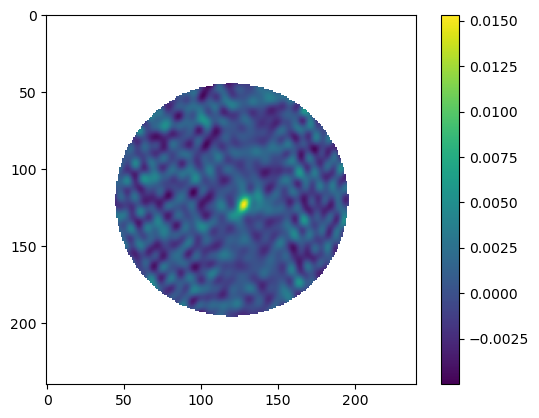

In [148]:
data_array = hdu.data[0][0]
maxloc = np.where(data_array == np.nanmax(data_array.flatten()))
print(maxloc)
aperture = CircularAnnulus((int(maxloc[0]),int(maxloc[1])), r_in=30, r_out=50)
rms=np.sqrt(aperture.do_photometry(data_array**2)[0]/aperture.area)[0] #Jy/beam

plt.imshow(data_array)
plt.colorbar()

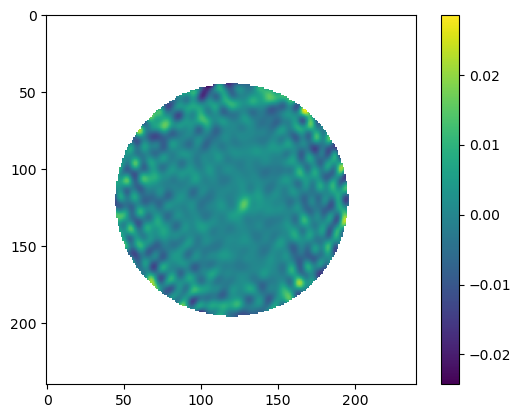

In [144]:
data_array_pbcor = hdu_pbcor.data[0][0]
plt.imshow(data_array_pbcor)
plt.colorbar()

In [145]:
isnan_sel = np.isnan(data_array_pbcor)
data_array_pbcor[isnan_sel] = 0.0

In [146]:
Fit_params = fit_2dgaussian(data_array_pbcor, maxloc[0], maxloc[1], fwhmx = beam[1]/cdelt, fwhmy = beam[0]/cdelt, theta=bpa*np.pi/180)

In [150]:
print(beam[0]/cdelt, beam[1]/cdelt, Fit_params[2], Fit_params[3], Fit_params[0], Fit_params[1])
pixscale = cdelt*u.deg

7.786744117739376 6.511080741881959 14.858454966897817 7.802214399021332 123.3851356955843 128.1319678887817


Here we see the best fit 2D Gaussian to the source emission is >1 pixel = 0.5 arcsec in both dimensions. We might consider this partically resolved and therefore want to integrate over the 2D gaussian of this size and amplitude to determine the total flux density of the source. 